In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(berufsgruppen=True, pos=True, word_features=True)
print('took: ',time.time()-start)

7501246
56138358
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_bg_pos_wFeatures_4
loading data...
37076 37076 11806 11806 0 0
took:  7.3125457763671875


In [ ]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features


In [5]:
from tensorflow.keras import *

In [6]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

bg_input = layers.Input(shape=(len(bg_train[0])))
b = layers.Dense(512, activation='relu')(bg_input)
b = layers.Dropout(0.5)(b)
b = layers.Dense(256, activation='relu')(b)

x = layers.concatenate([vw, f, p, b])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softplus')(x)
model = models.Model(inputs=[vector_window_input, wf_input, pos_input, bg_input], outputs=[out])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=[x_test, wf_test, pos_test, bg_test], y=y_test)

batch_size=32
history = model.fit([x_train, wf_train, pos_train, bg_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test, pos_test, bg_test], y_test))

Build model...


2020-05-20 14:30:56 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


11806/11806 [==============================] - 28s 2ms/sample - loss: 2.0861 - acc: 0.0475
Train on 37076 samples, validate on 11806 samples


2020-05-20 14:31:27 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37076/37076 [==============================] - 201s 5ms/sample - loss: 0.7765 - acc: 0.7155 - val_loss: 0.6610 - val_acc: 0.7580
Epoch 2/5
37076/37076 [==============================] - 215s 6ms/sample - loss: 0.5784 - acc: 0.7912 - val_loss: 0.5085 - val_acc: 0.8246
Epoch 3/5
37076/37076 [==============================] - 251s 7ms/sample - loss: 0.4542 - acc: 0.8424 - val_loss: 0.4967 - val_acc: 0.8266
Epoch 4/5
37076/37076 [==============================] - 211s 6ms/sample - loss: 0.4067 - acc: 0.8575 - val_loss: 0.4481 - val_acc: 0.8547
Epoch 5/5
37076/37076 [==============================] - 211s 6ms/sample - loss: 0.3724 - acc: 0.8709 - val_loss: 0.4370 - val_acc: 0.8563


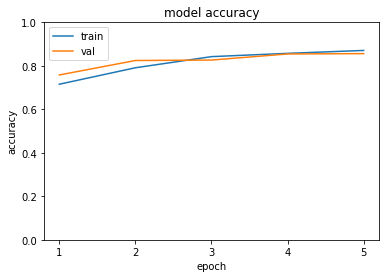

In [7]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [8]:

# predict test data
y_pred = model.predict([x_test, wf_test, pos_test, bg_test])

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [10]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)

|           |   Ausbildung |   Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+---------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.78268  | 0.27027 |    0.608355 |     0.584946 |  0.985849 |      0.818849 |    0.767496 |  0.94932  |
| recall    |     0.869328 | 0.15625 |    0.326331 |     0.764761 |  0.945701 |      0.863226 |    0.918994 |  0.913624 |
| f1        |     0.823732 | 0.19802 |    0.424795 |     0.662876 |  0.965358 |      0.840452 |    0.836441 |  0.93113  |
f1 average:  0.7103504105976999
f1 average:  0.6310525125857677


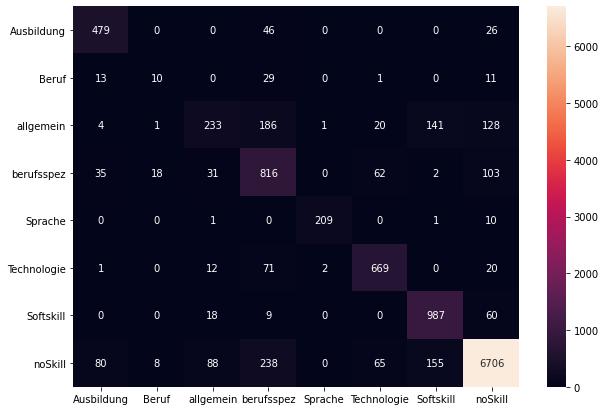

In [11]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [12]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6706


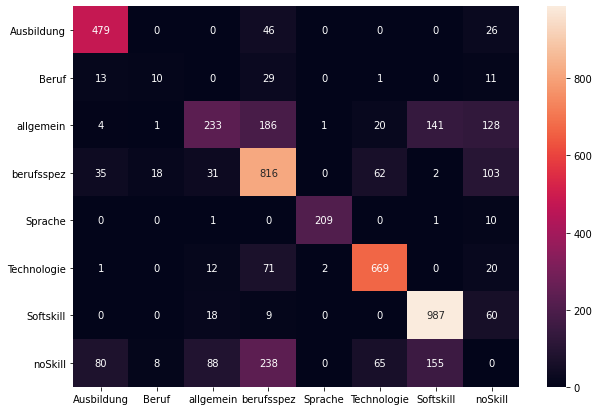

In [13]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')